**Propuestas por hacer:**

1.   Filtrar palabras/emojis por hora (o media, cuarto de hora)
2.   Análisis Emojis 

______________

**Contenido del notebook:**

1. Librerías
2. Tratamiento y exploración de de datos
3. Definición de funciones*
4. Análisis e interpretación de insights
5. Modelo
6. Conclusiones

**Tal vez no se incluya*
_________________

# Librerías

In [1]:
import pandas as pd # trabajar dataframes
import datetime # fechas y horas
import re # texto
import string # texto2
import matplotlib.pyplot as plt # graficar
import seaborn as sns # graficar2
import io

from sklearn.feature_extraction.text import CountVectorizer # NLP
from wordcloud import WordCloud
import emoji

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_rows', 500)

# Tratamiento de datos

## Importación del *raw data*

Para seleccionar el archivo desde la compu (también se puede hacer desde Drive: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92):

In [2]:
path = '../../../../Downloads/Chat de WhatsApp.txt'
df_whats = pd.read_csv(path, sep='delimiter', header=None, encoding='utf8', engine='python')

In [3]:
df_whats.head()

0
0  8/3/19 13:11 - Los mensajes en este grupo ahor...
1  8/3/19 13:04 - ‎Jy creó el grupo "Bendita entr...
2                       8/3/19 13:11 - ‎Jy te añadió
3                           8/3/19 13:14 - Jesús: XD
4  8/3/19 13:15 - Jn: Quien es Kike y quien ea Lalo?

In [4]:
df_whats.shape

(7192, 1)

## Limpieza del *raw data*

In [5]:
date = []
time = []
persons = []
messages = []
errors = []
for row in range(len(df_whats)):
    whats = df_whats.iloc[row][0].split(' - ')
    try:
        messages.append(whats[1].split(':')[1])
        date.append(whats[0].split()[0])
        time.append(whats[0].split()[1])
        persons.append(whats[1].split(':')[0])
    except:
        errors.append(row)

### Análisis de errores

In [6]:
print('Errores totales en la conversación de whats: ', len(errors))

Errores totales en la conversación de whats:  15


## Creación del *dataframe*

In [7]:
dict_data = {'fecha':date, 'hora':time, 'persona':persons, 'mensaje':messages}
df = pd.DataFrame(dict_data)

In [8]:
df.head(10)

fecha   hora             persona                          mensaje
0  8/3/19  13:14               Jesús                               XD
1  8/3/19  13:15                  Jn   Quien es Kike y quien ea Lalo?
2  8/3/19  13:15                  Jn                                🤔
3  8/3/19  13:16  +52 1 55 2563 8294             <Multimedia omitido>
4  8/3/19  13:17                  Jn                          Va jeje
5  8/3/19  13:25                  Jy                Naaa mms Jonathan
6  8/3/19  13:25                  Jy                         Jajajaja
7  8/3/19  13:25                  Jy             <Multimedia omitido>
8  8/3/19  13:27                  Lo             <Multimedia omitido>
9  8/3/19  13:29                  Jn                      Oooo perdon

# Definición de Funciones

In [9]:
def limpia_fechas(fecha):
    fecha_lista = [int(element) for element in fecha.split('/')]
    return datetime.datetime(2000 + fecha_lista[2], fecha_lista[1], fecha_lista[0])

In [10]:
def limpia_horas(hora):
    hora_lista = [int(element) for element in hora.split(':')]
    return datetime.time(hora_lista[0], hora_lista[1])

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    # ja equivale a jajajaja/ja/jajaj
    text = re.sub(r'(ja)[ja]*', 'jajaja', text)
    text = re.sub(r'(je)[je]*', 'jejeje', text)
    return text

In [12]:
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

In [13]:
def extract_text(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

# Tratamiento de datos

## Limpieza de datos

In [14]:
nombres = {'Jesús': 'x1',
 'Jn': 'x2',
 '+52 1 55 2563 8294': 'x3',
 'Jy': 'x4',
 'Lo': 'x5',
 'Cr': 'x6',
 'Ro': 'x7',
 'Ae': 'x8',
 'Id': 'x9',
 'In': 'x10',
 '+52 1 55 4927 1613': 'x11',
 'Iván DAN': 'x10'}

df['persona'] = df['persona'].map(nombres).copy()

In [15]:
df.tail(10)

fecha   hora persona                                            mensaje
7167  1/1/20  01:09      x8                                           JajajJaj
7168  1/1/20  01:09      x2                                               🤣🤣🤣🤣
7169  1/1/20  01:10      x5   Es que tengo que aprovechar y enamorar a mi s...
7170  1/1/20  01:10      x5                               <Multimedia omitido>
7171  1/1/20  01:13      x2                                        Ajalas!!!!!
7172  1/1/20  01:13      x2          Eso es bajar de pechito el balón jejejeje
7173  1/1/20  01:13      x6                               <Multimedia omitido>
7174  1/1/20  01:14      x5                               <Multimedia omitido>
7175  1/1/20  01:23      x8                               <Multimedia omitido>
7176  1/1/20  01:34      x5                               <Multimedia omitido>

In [16]:
df.shape

(7177, 4)

In [17]:
df['fecha'] = df['fecha'].apply(limpia_fechas)

df['hora'] = df['hora'].apply(limpia_horas)

Le quitamos los días 24, 25, 30 y 31 de diciembre:

In [18]:
df_texto = df[(df['fecha'] < datetime.datetime(2019,12,31))&((df['fecha'] != datetime.datetime(2019,12,25))|(df['fecha'] != datetime.datetime(2019,12,24)))]

In [19]:
df_texto.shape

(7137, 4)

Le quitamos los emojis, los stickers y los mensajes que solo sean un espacio:

df_texto['mensaje'] = df_texto['mensaje'].apply(extract_text).copy()
df_texto = df_texto[(df_texto['mensaje'] != ' <Multimedia omitido>')&(df_texto['mensaje'] != ' ')].copy()

df_texto.shape

También le quitamos los mensajes eliminados y que nunca llegaron...

In [20]:
df_texto = df_texto[~((df_texto['mensaje'] == ' Este mensaje fue eliminado')|(df_texto['mensaje'] == ' Esperando este mensaje'))].copy()

In [21]:
df_texto.shape

(7107, 4)

In [22]:
print('Tenemos mensajes desde', df_texto['fecha'].min().strftime("%d/%m/%Y"), 'hasta', df_texto['fecha'].max().strftime("%d/%m/%Y"))
print('Y desde las', df_texto['hora'].min().strftime("%H:%M"), 'hasta las', df_texto['hora'].max().strftime("%H:%M"))

Tenemos mensajes desde 08/03/2019 hasta 30/12/2019
Y desde las 00:00 hasta las 23:59


# Creación de Features

##  Label minutes

In [23]:
cont = 0
dict_time = {}
for hour in range(0, 24):
    for minute in range(0, 60):
        cont += 1
        dict_time[datetime.time(hour, minute)] = cont
        #print(cont, '\t', hour, ':', minute)

In [24]:
df_texto['lab_minutes'] = df_texto['hora'].map(dict_time).copy()

df_texto.reset_index(drop=True, inplace=True)

In [25]:
df_texto.head(11)

fecha      hora persona                          mensaje  lab_minutes
0  2019-03-08  13:14:00      x1                               XD          795
1  2019-03-08  13:15:00      x2   Quien es Kike y quien ea Lalo?          796
2  2019-03-08  13:15:00      x2                                🤔          796
3  2019-03-08  13:16:00      x3             <Multimedia omitido>          797
4  2019-03-08  13:17:00      x2                          Va jeje          798
5  2019-03-08  13:25:00      x4                Naaa mms Jonathan          806
6  2019-03-08  13:25:00      x4                         Jajajaja          806
7  2019-03-08  13:25:00      x4             <Multimedia omitido>          806
8  2019-03-08  13:27:00      x5             <Multimedia omitido>          808
9  2019-03-08  13:29:00      x2                      Oooo perdon          810
10 2019-03-08  13:29:00      x2        Siempre contra el negro 😭          810

df_texto['mensaje'] = df_texto['mensaje'].map(lambda x: x[1:])

df_texto.to_csv('Data/Chat_limpio.csv', index=False)

path = 'Data/Chat_limpio.csv'

df_texto = pd.read_csv(path)

In [59]:
df_texto.shape

(4894, 5)

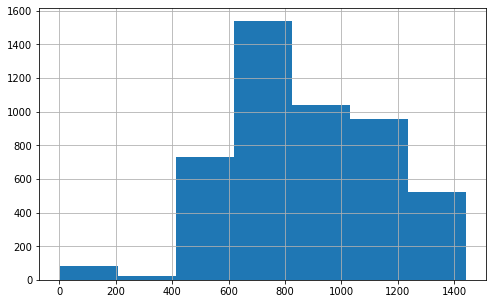

In [60]:
plt.figure(figsize=(8, 5))
df_texto.lab_minutes.hist(bins=7)
plt.show()

In [61]:
df_texto.shape

(4894, 5)

In [62]:
#df_mens = pd.DataFrame(df.groupby(['lab_minutes']).count()['mensaje'])
df_mens = pd.DataFrame(df_texto.groupby(['lab_minutes']).count()['mensaje'])

In [63]:
df_mens.head()

mensaje
lab_minutes         
1                  4
2                  2
3                  6
4                  3
9                  2

In [ ]:
'''
x = df_mens.index.get_level_values(level=0).tolist()

y = df_mens['mensaje'].tolist()

plt.figure(figsize=(9, 7))
plt.plot(x, y, 'o', color='#96bc9e')
plt.show()
'''

"\nx = df_mens.index.get_level_values(level=0).tolist()\n\ny = df_mens['mensaje'].tolist()\n\nplt.figure(figsize=(9, 7))\nplt.plot(x, y, 'o', color='#96bc9e')\nplt.show()\n"

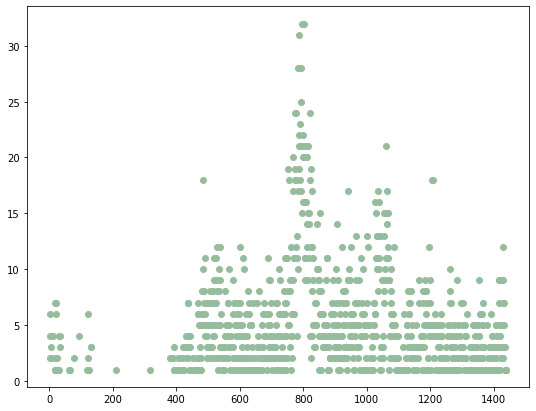

In [64]:
x = df_mens.index.get_level_values(level=0).tolist()

y = df_mens['mensaje'].tolist()

plt.figure(figsize=(9, 7))
plt.plot(x, y, 'o', color='#96bc9e')
plt.show()

# Cluster

In [65]:
X = pd.DataFrame({'minutos':x, 'num_mensajes':y})

In [66]:
X.shape

(933, 2)

In [67]:
X_result = X.copy()

In [68]:
X_result.head()

minutos  num_mensajes
0        1             4
1        2             2
2        3             6
3        4             3
4        9             2

In [69]:
lst_in = []
for k in range(2,11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    lst_in.append(km.inertia_)

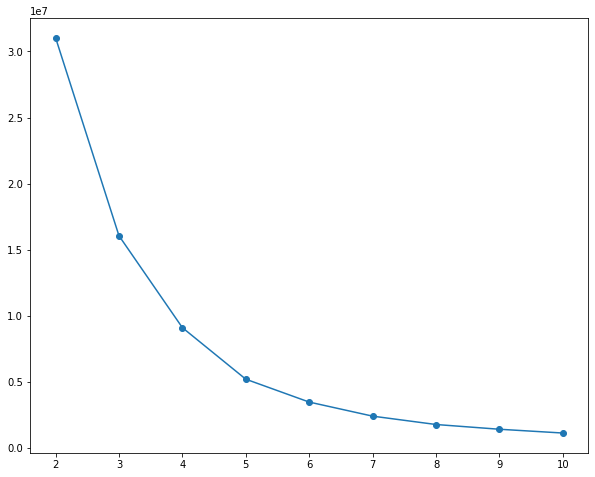

In [70]:
plt.figure(figsize=(10, 8))
plt.plot(range(2,11),lst_in, marker='o')
plt.show()

Tomando la regla del *codito*, el número de clústers debería ser 4, pero el problema necesita tener 3 o 5 grupos, así que tomaremos 5 como el número de clústers.


In [71]:
n=5
agg = AgglomerativeClustering(n_clusters=n)
km = KMeans(n_clusters=n, random_state=123)
gmm = GaussianMixture(n_components=n, random_state=123)

km.fit(X)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=123, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [72]:
X_result['cl_agg'] = agg.fit_predict(X)
X_result['cl_km'] = km.predict(X)
X_result['cl_gmm'] = gmm.predict(X)

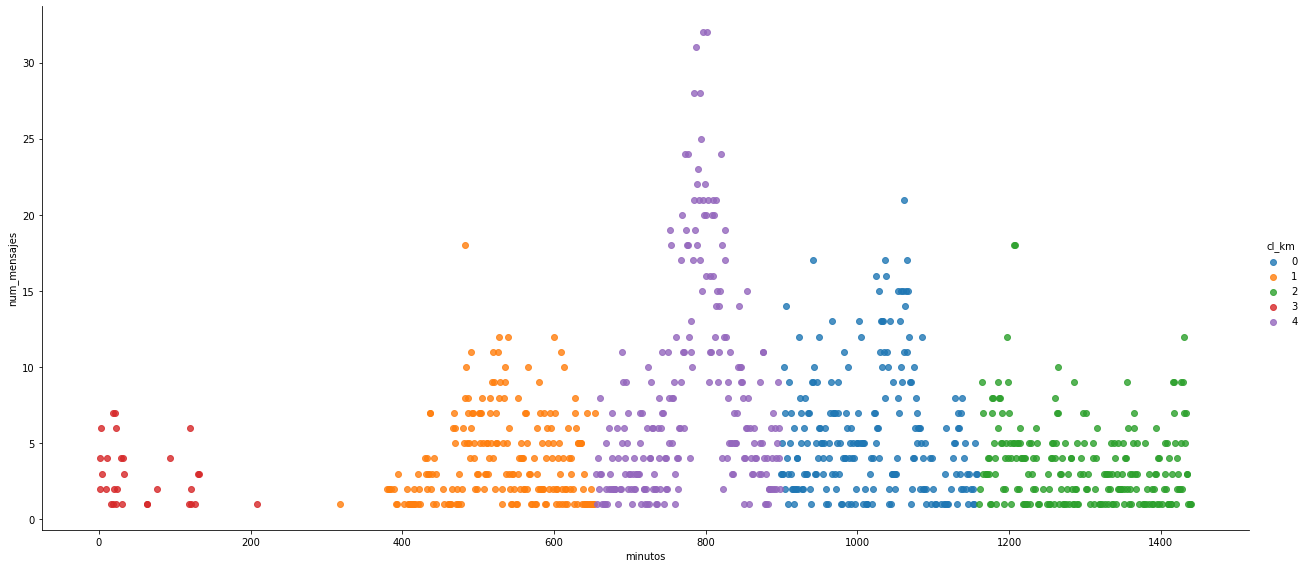

In [73]:
sns.lmplot(x = 'minutos', y = 'num_mensajes', data=X_result, height=8, aspect=2.2, fit_reg=False, hue='cl_km')
plt.show()

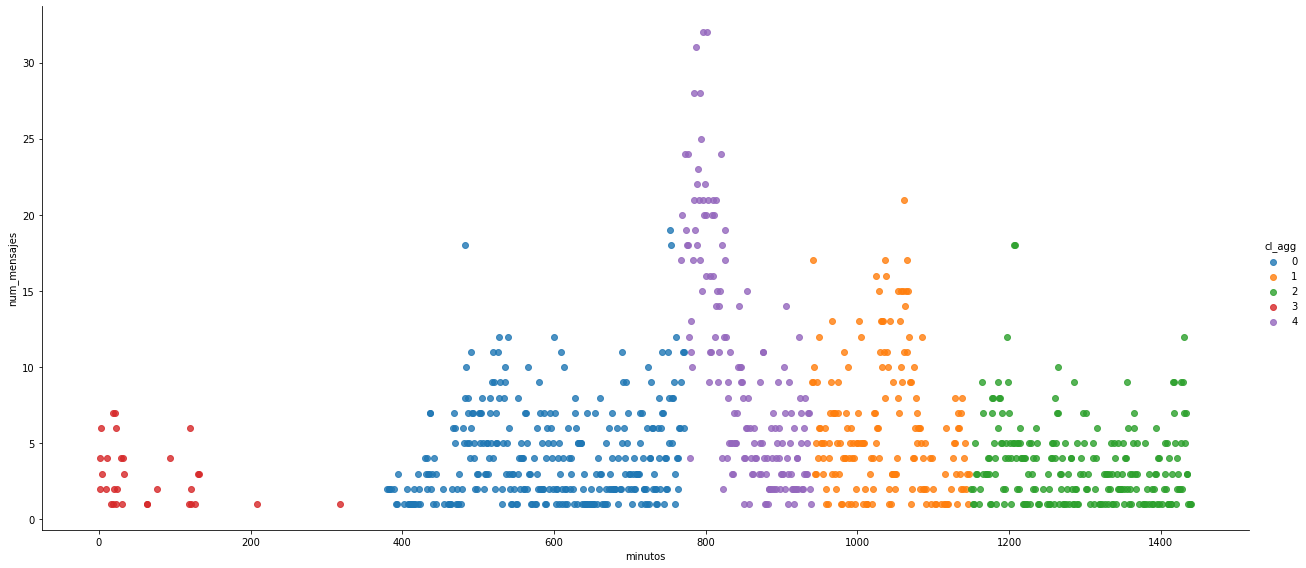

In [74]:
sns.lmplot(x = 'minutos', y = 'num_mensajes', data=X_result, height=8, aspect=2.2, fit_reg=False, hue='cl_agg')
plt.show()

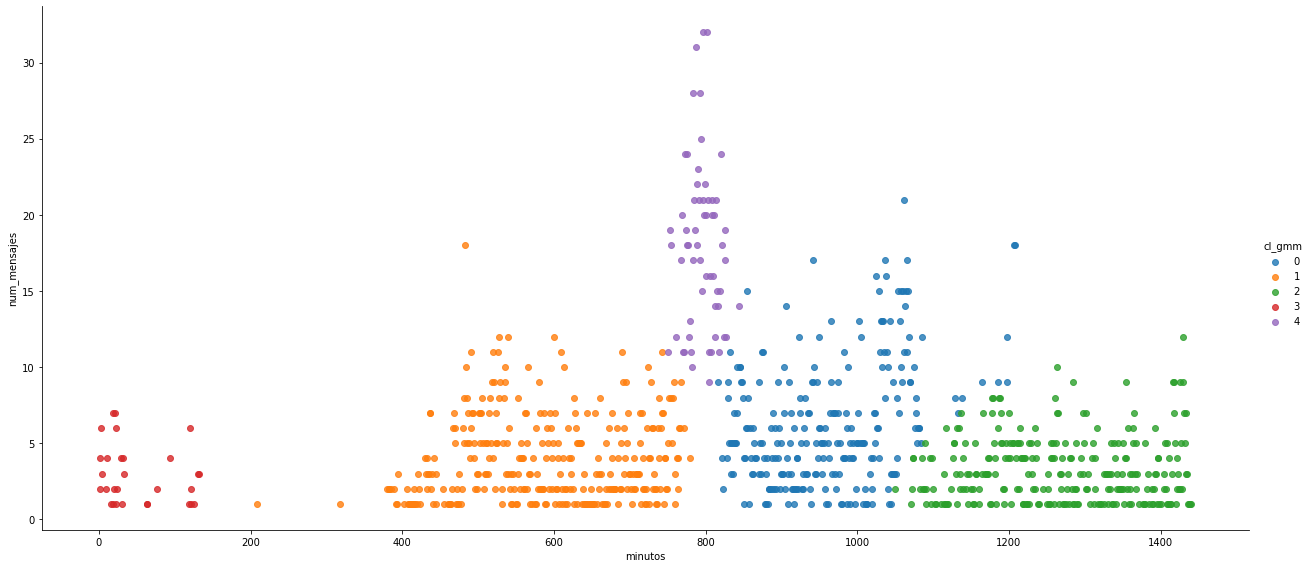

In [75]:
sns.lmplot(x = 'minutos', y = 'num_mensajes', data=X_result, height=8, aspect=2.2, fit_reg=False, hue='cl_gmm')
plt.show()

___________________________

## Análisis de Resultados

### Cluster 4 (salida MUY tarde)

In [76]:
list_cluster = []
list_fechai = []
list_fechaf = []
list_num_whats = []
for i in range(5):
    list_filter = X_result[X_result['cl_km'] == i]['minutos'].to_list()
    globals()['kmcl_' + str(i)] =  df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]
    list_cluster.append('Cluster ' + str(i))
    list_fechai.append(globals()['kmcl_' + str(i)]['hora'].min().strftime("%H:%M"))
    list_fechaf.append(globals()['kmcl_' + str(i)]['hora'].max().strftime("%H:%M"))
    list_num_whats.append(len(globals()['kmcl_' + str(i)]))

clusters_resum = pd.DataFrame({'Núm Cluster': list_cluster, 'Total Mensajes': list_num_whats, 'Desde': list_fechai, 'Hasta': list_fechaf})

AttributeError: 'str' object has no attribute 'strftime'

In [53]:
clusters_resum

Núm Cluster  Total Mensajes  Desde  Hasta
0   Cluster 0            1264  14:58  19:16
1   Cluster 1             844  05:17  10:53
2   Cluster 2             826  19:19  23:59
3   Cluster 3              86  00:00  03:28
4   Cluster 4            1856  10:54  14:57

In [ ]:
list_filter = X_result[X_result['cl_km'] == 4]['minutos'].to_list()

km_cl4 = df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]

In [ ]:
km_cl4[['fecha', 'hora']].describe()

fecha      hora
count                  1858      1858
unique                  173       232
top     2019-11-05 00:00:00  13:06:00
freq                     50        32
first   2019-03-08 00:00:00       NaN
last    2019-12-22 00:00:00       NaN

In [ ]:
#km_cl4['hora'].min()
print('Este cluster abarca el horario de', km_cl4['hora'].min().strftime("%H:%M"), 'a las', km_cl4['hora'].max().strftime("%H:%M")) 

datetime.time(10, 54)

In [ ]:
km_cl4['hora'].max()

datetime.time(14, 57)

In [ ]:
km_cl4.head()

fecha      hora persona                          mensaje  lab_minutes
0 2019-03-08  13:14:00      x1                               XD          795
1 2019-03-08  13:15:00      x2   Quien es Kike y quien ea Lalo?          796
2 2019-03-08  13:17:00      x2                          Va jeje          798
3 2019-03-08  13:25:00      x4                Naaa mms Jonathan          806
4 2019-03-08  13:25:00      x4                         Jajajaja          806

_____________________

### Cluster 0 (entrada/oxxo)

In [ ]:
list_filter = X_result[X_result['cl_km'] == 0]['minutos'].to_list()

km_cl0 = df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]

In [ ]:
km_cl0[['fecha', 'hora']].describe()

fecha      hora
count                  1272      1272
unique                  101       226
top     2019-11-04 00:00:00  17:41:00
freq                     60        21
first   2019-03-08 00:00:00       NaN
last    2019-12-27 00:00:00       NaN

In [ ]:
km_cl0['hora'].min()

datetime.time(14, 58)

In [ ]:
km_cl0['hora'].max()

datetime.time(19, 16)

In [ ]:
km_cl0.head()

fecha      hora persona  \
7  2019-03-08  19:04:00      x5   
13 2019-03-12  17:06:00      x2   
14 2019-03-12  17:08:00      x6   
15 2019-03-12  17:08:00      x2   
16 2019-03-12  17:08:00      x2   

                                              mensaje  lab_minutes  
7                        Que disfruten su fin chicos          1145  
13                         Si lograrán irse a tiempo?         1027  
14   Depende de si @5215522630940 entretiene lo su...         1029  
15                                           Jejejeje         1029  
16                                            A las 5         1029

_____________________

### Cluster 3 (comida/chisme)

In [ ]:
list_filter = X_result[X_result['cl_km'] == 3]['minutos'].to_list()

km_cl3 = df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]

In [ ]:
km_cl3[['fecha', 'hora']].describe()

fecha      hora
count                    86        86
unique                   10        30
top     2019-11-22 00:00:00  00:18:00
freq                     21         7
first   2019-04-02 00:00:00       NaN
last    2019-12-12 00:00:00       NaN

In [ ]:
km_cl3['hora'].min()

datetime.time(0, 0)

In [ ]:
km_cl3['hora'].max()

datetime.time(3, 28)

In [ ]:
km_cl3.head()

fecha      hora persona  \
187 2019-04-02  00:00:00      x2   
188 2019-04-02  00:00:00      x4   
189 2019-04-02  00:00:00      x4   
190 2019-04-02  00:01:00      x6   
191 2019-04-02  00:01:00      x2   

                                               mensaje  lab_minutes  
187                                   Como van amigos?            1  
188                                     Ya solo voy yo            1  
189                              Acabo de dejar a Lalo            1  
190                                         Ya en casa            2  
191   Que bien, @5215522630940 como cuanto tiempo m...            2

_____________________

### Cluster 1 (salida/chisme vespertino)

In [ ]:
list_filter = X_result[X_result['cl_km'] == 1]['minutos'].to_list()

km_cl1 = df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]

In [ ]:
km_cl1[['fecha', 'hora']].describe()

fecha      hora
count                   852       852
unique                   88       217
top     2019-11-08 00:00:00  08:02:00
freq                     42        18
first   2019-03-22 00:00:00       NaN
last    2019-12-27 00:00:00       NaN

In [ ]:
km_cl1['hora'].min()

datetime.time(5, 17)

In [ ]:
km_cl1['hora'].max()

datetime.time(10, 53)

In [ ]:
km_cl1.head()

fecha      hora persona  \
94 2019-03-22  07:59:00      x4   
95 2019-03-22  08:00:00      x6   
96 2019-03-22  08:00:00      x6   
97 2019-03-22  08:01:00      x4   
98 2019-03-22  08:02:00      x4   

                                              mensaje  lab_minutes  
94    @5215521392914 recomiéndame un buen vino tinto           480  
95                          A mi me gustan los merlot          481  
96                                         Son dulces          481  
97   Si a mi también pero alguna márca en especial...          482  
98                                        O Casillero          483

_____________________

### Cluster 2 (salida tarde)

In [ ]:
list_filter = X_result[X_result['cl_km'] == 2]['minutos'].to_list()

km_cl2 = df_texto[df_texto['lab_minutes'].apply(lambda x: x in list_filter)]

In [ ]:
km_cl2[['fecha', 'hora']].describe()

fecha      hora
count                   827       827
unique                   71       228
top     2019-04-09 00:00:00  20:07:00
freq                     93        18
first   2019-03-13 00:00:00       NaN
last    2019-12-27 00:00:00       NaN

In [ ]:
km_cl2['hora'].min()

datetime.time(19, 19)

In [ ]:
km_cl2['hora'].max()

datetime.time(23, 59)

In [ ]:
km_cl2.head()

fecha      hora persona  \
78  2019-03-13  22:08:00      x5   
79  2019-03-13  22:11:00      x4   
93  2019-03-20  21:22:00      x2   
117 2019-03-25  20:14:00      x3   
118 2019-03-25  20:14:00      x3   

                                          mensaje  lab_minutes  
78    Y nosotros hasta que salimos de la oficina          1329  
79          Nosotros venimos riendo con puro meme         1332  
93                            Ese si esta chiduuu         1283  
117                                   Apenas salí         1215  
118                                Kill me please         1215

____________________

# Limpieza de texto

list_clusters = ['km_cl' + str(i) for i in range(5)]

km_cl0.shape

km_cl0['mensaje'] = km_cl0['mensaje'].apply(extract_text).copy()

km_cl0 = km_cl0[km_cl0['mensaje'] != ' <Multimedia omitido>']
km_cl0.shape

______________

list_clusters

for cluster in list_clusters:
    print(globals()[cluster].shape)
    globals()[cluster]['mensaje'] = globals()[cluster]['mensaje'].apply(extract_text).copy()
    globals()[cluster] = globals()[cluster][globals()[cluster]['mensaje'] != ' <Multimedia omitido>']
    globals()[cluster] = globals()[cluster][globals()[cluster]['mensaje'] != ' ']
    print(globals()[cluster].shape)
    print('\n\n')

km_cl0.reset_index(drop=True, inplace=True)
km_cl1.reset_index(drop=True, inplace=True)
km_cl2.reset_index(drop=True, inplace=True)
km_cl3.reset_index(drop=True, inplace=True)
km_cl4.reset_index(drop=True, inplace=True)

___________________

km_cl0.head()

In [ ]:
path = '../../../../Downloads/stopwords2.txt'
stopword = pd.read_csv(path, encoding = 'latin1', header = None)[0].tolist()

cv = CountVectorizer(stop_words = stopword)

wc = WordCloud(stopwords=stopword, background_color = "black", colormap = "Dark2",
               max_font_size=150, random_state=42, width=800, height=600, max_words=100)

In [ ]:
list_clusters = ['km_cl' + str(i) for i in range(5)]

km_cl0 de 14:58 a 19:16


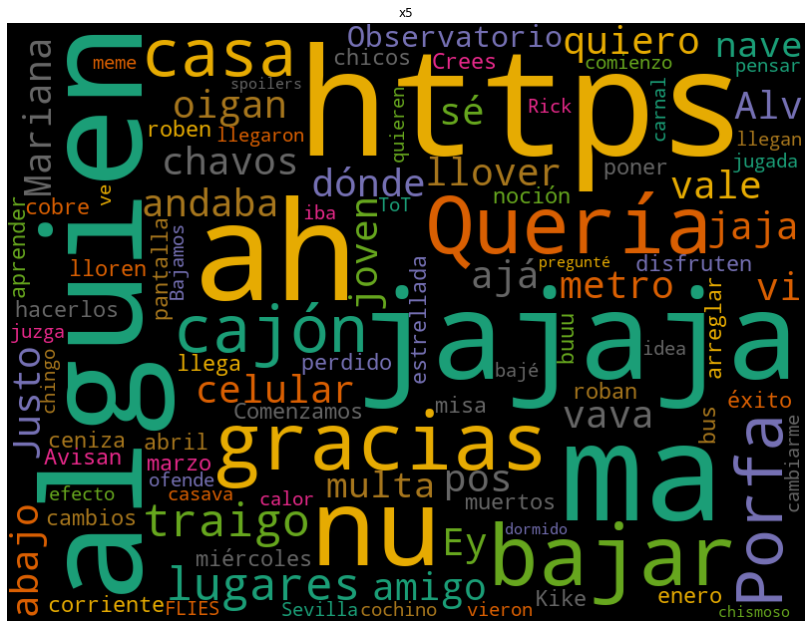

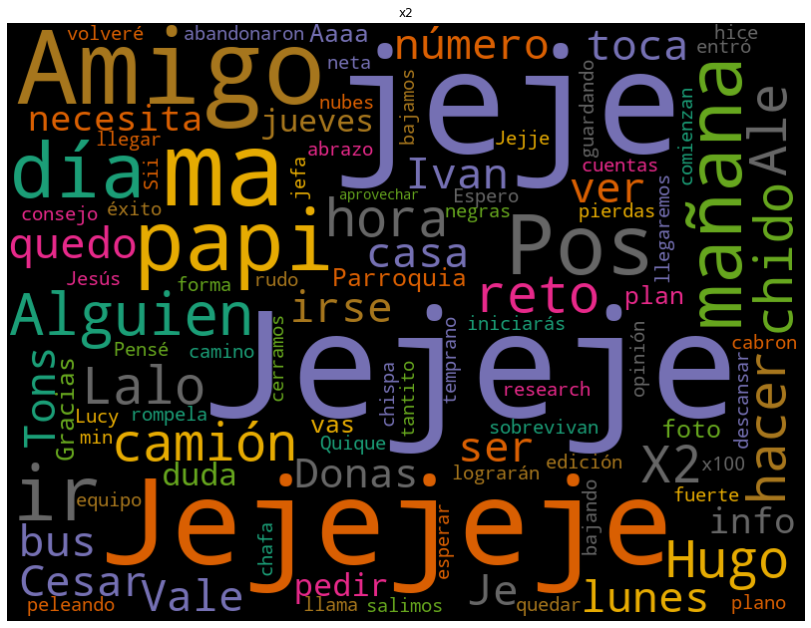

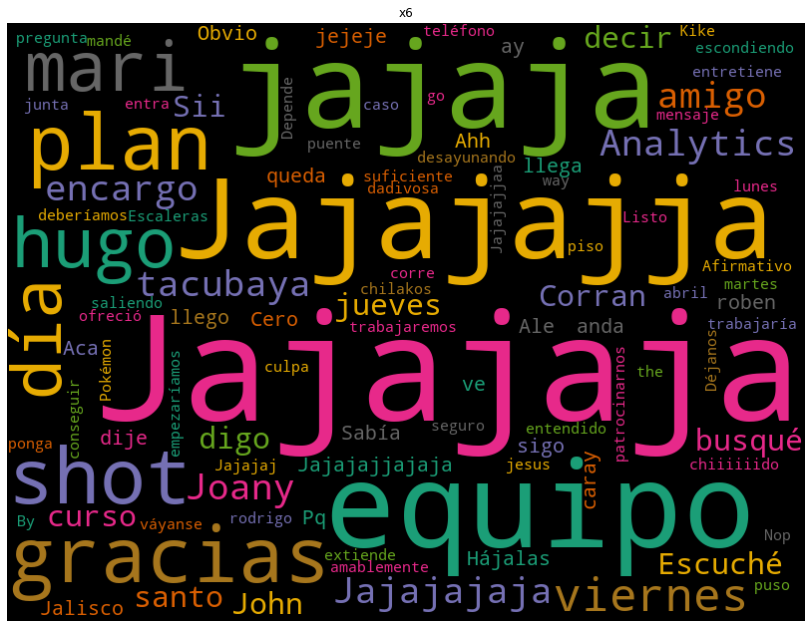

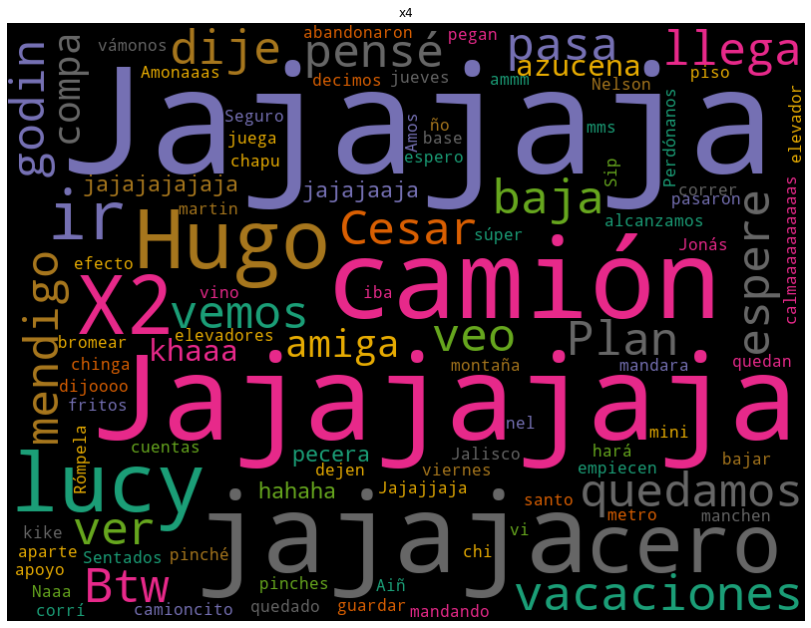

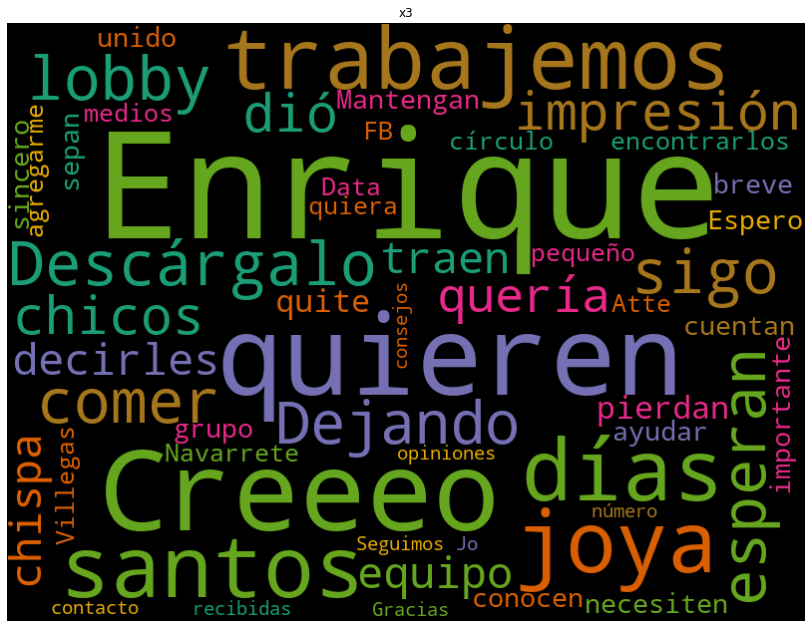

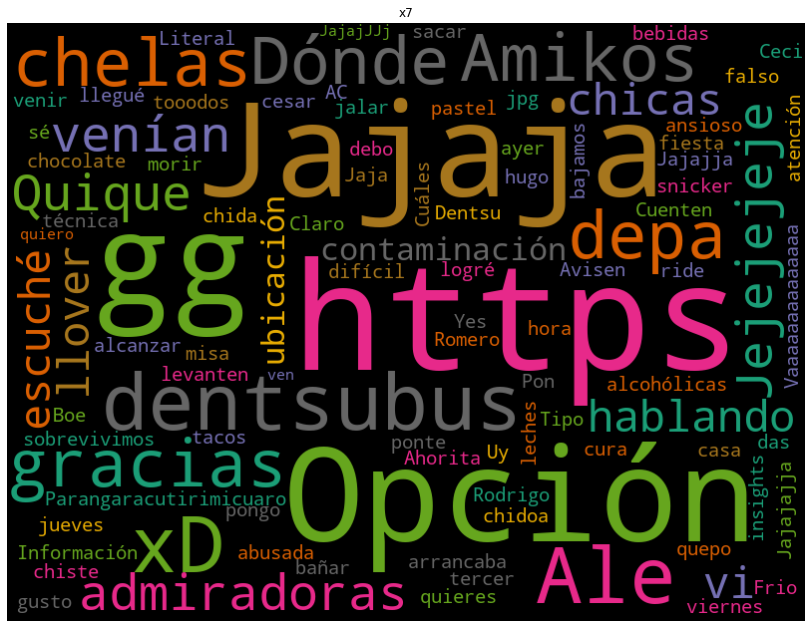

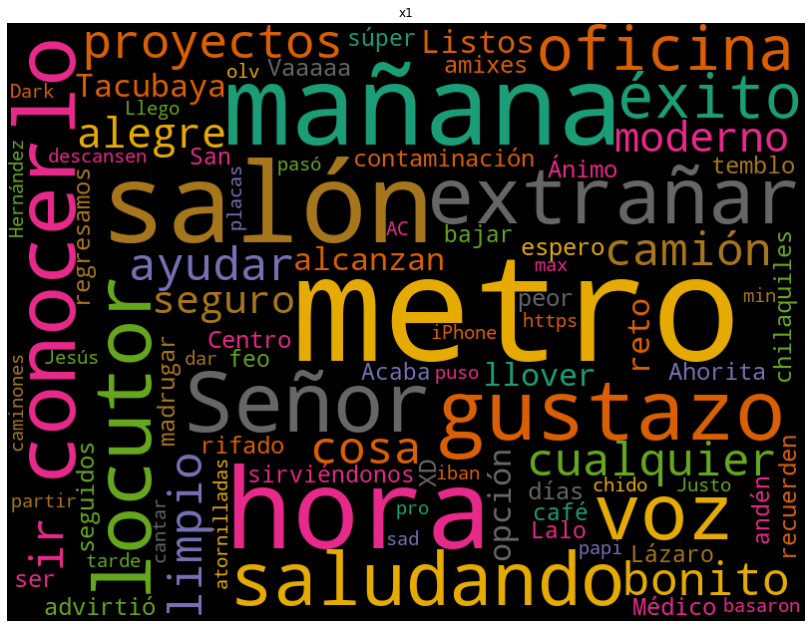

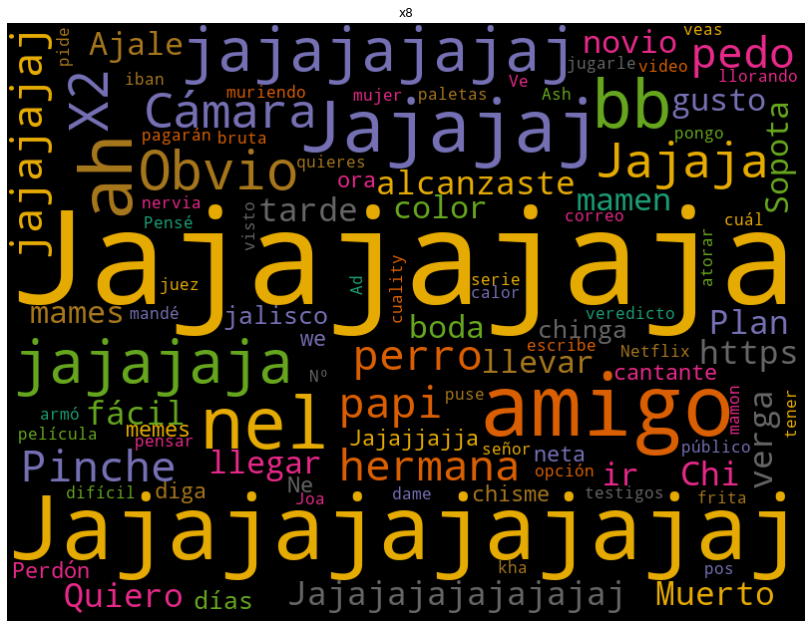

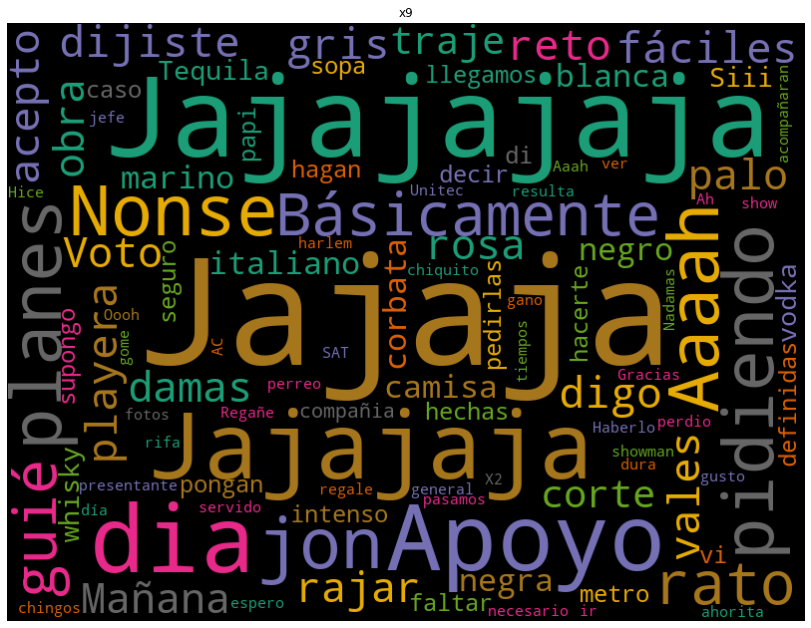

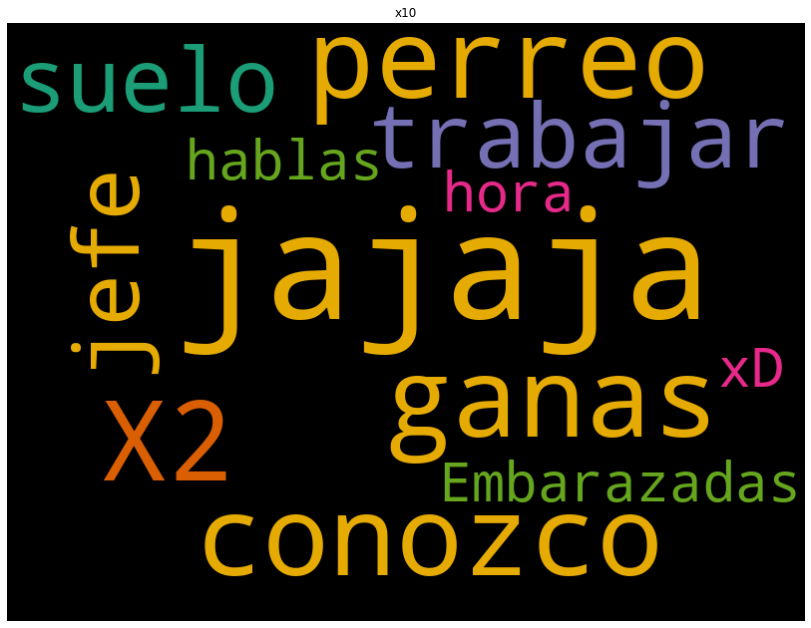

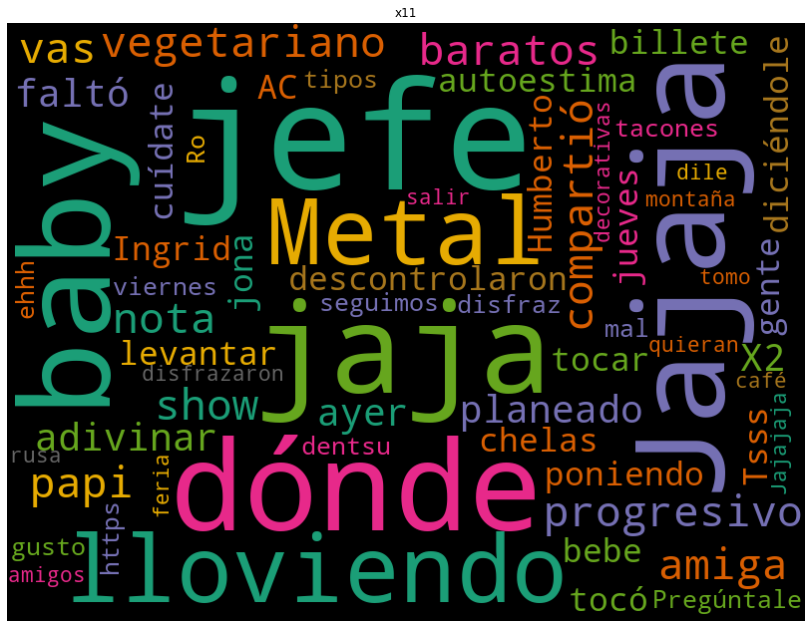




km_cl1 de 05:17 a 10:53


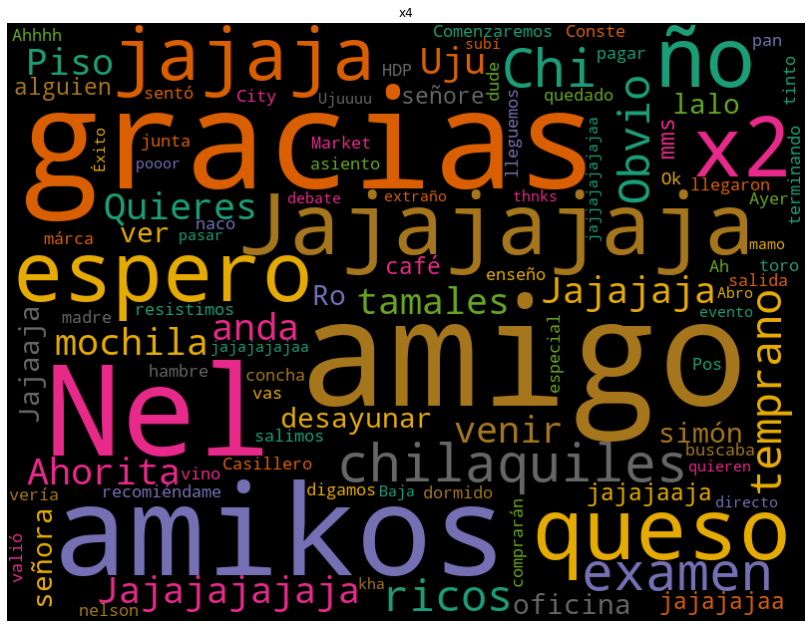

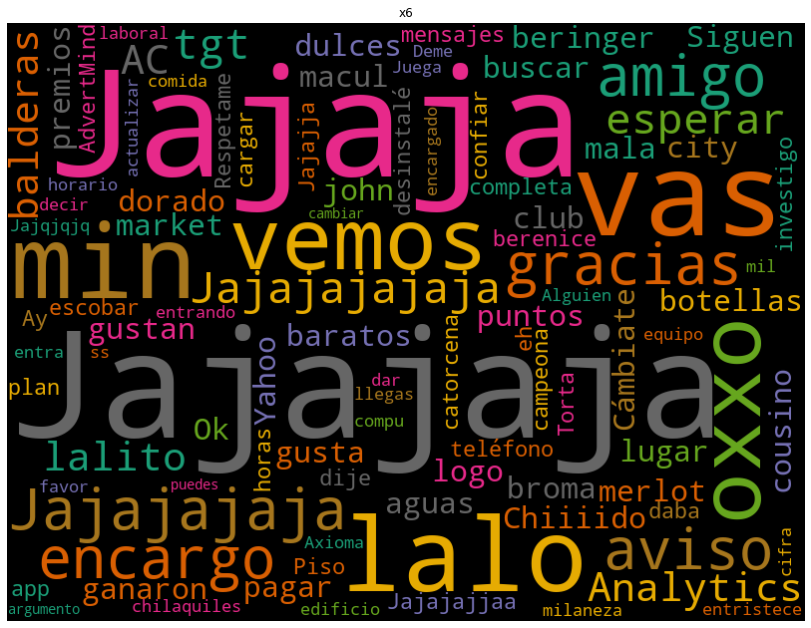

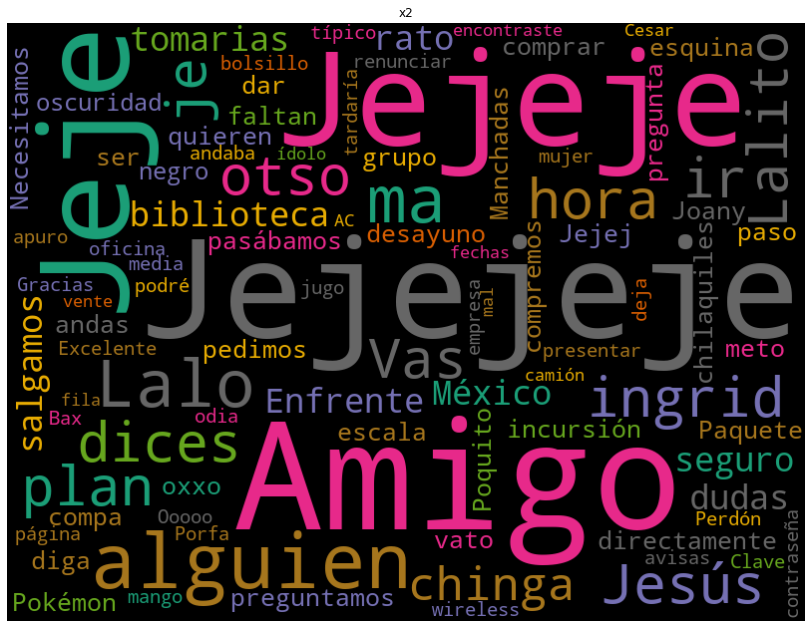

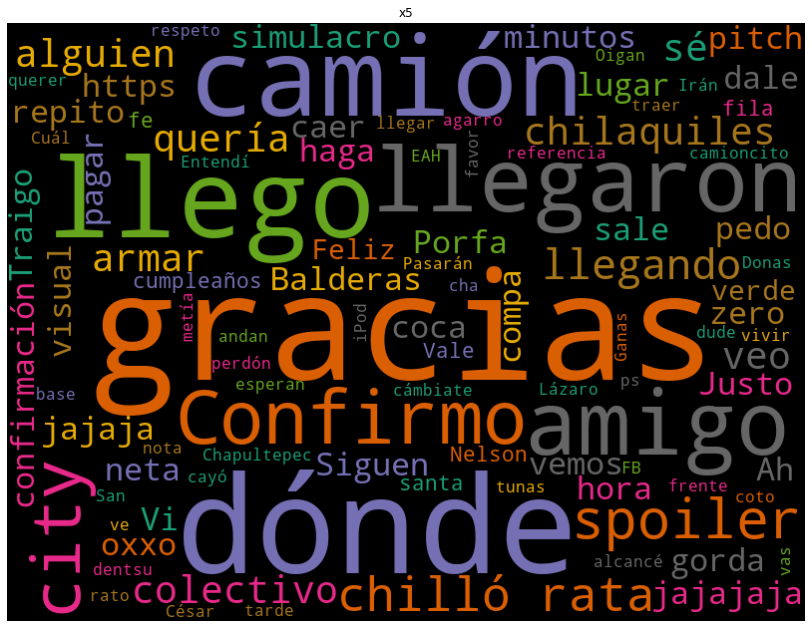

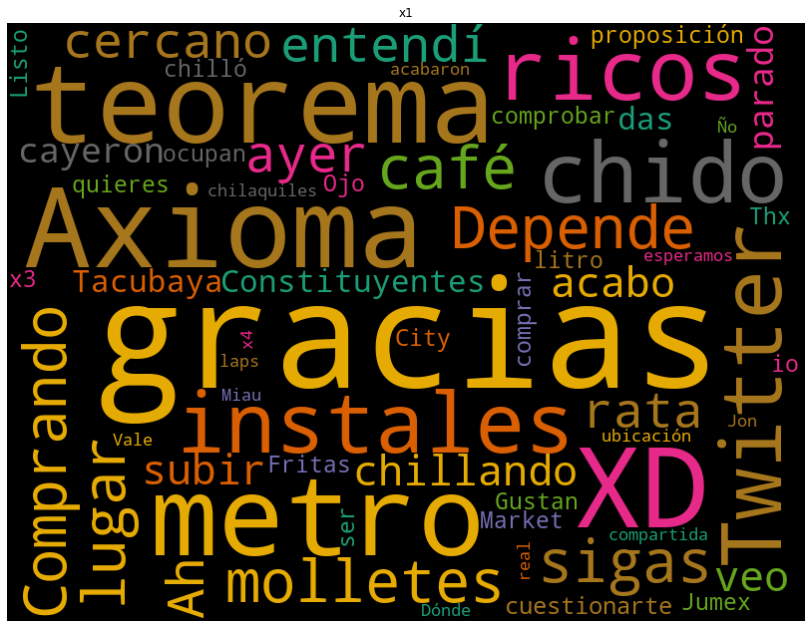

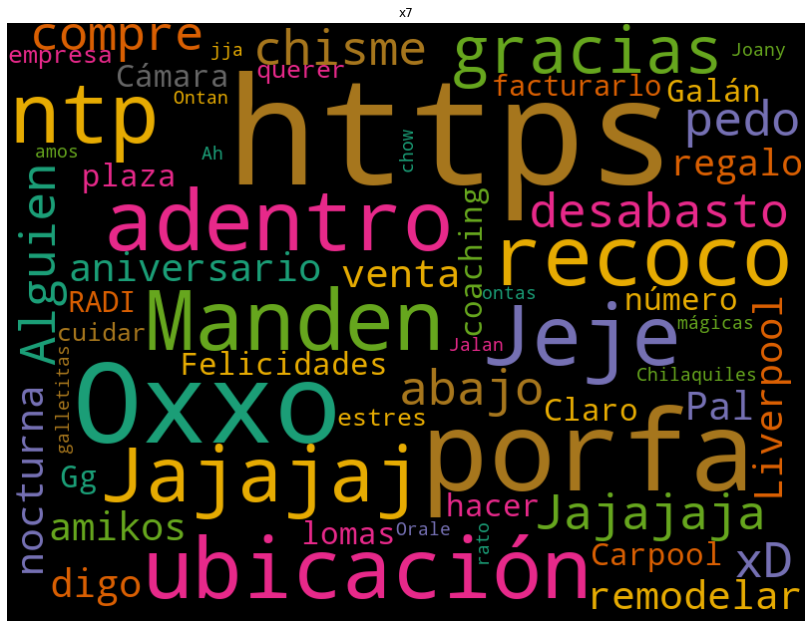

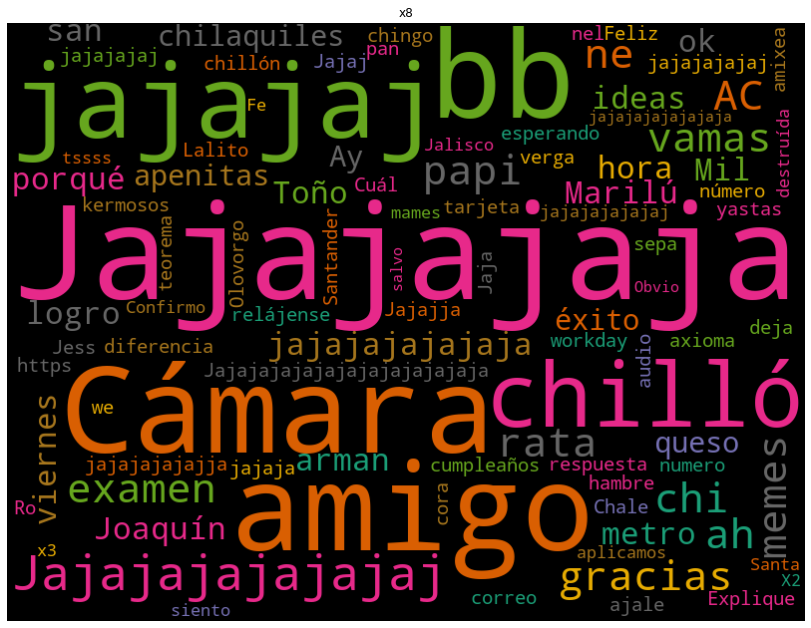

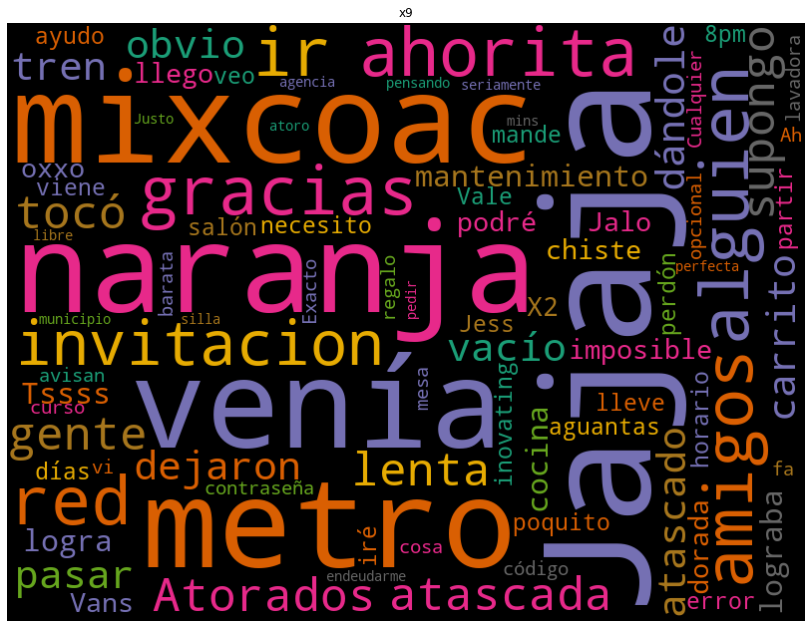

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
for cluster in list_clusters:
    mess = cluster + ' de ' + globals()[cluster]['hora'].min().strftime("%H:%M") + ' a ' + globals()[cluster]['hora'].max().strftime("%H:%M")
    print(mess)
    list_persons = globals()[cluster]['persona'].unique().tolist()
    for persona in list_persons:
        texto = ' '
        for row in globals()[cluster][globals()[cluster]['persona'] == persona].index.tolist():
            texto += globals()[cluster]['mensaje'].loc[row]

        #texto_cv = cv.fit_transform(texto.split())
        #data_texto = pd.DataFrame(texto_cv.toarray(), columns=cv.get_feature_names())

        wc.generate(texto)
        plt.subplots(figsize = (21, 11))
        #plt.imshow(wc)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(persona)
        plt.show()
    print('\n\n')

In [ ]:
for cluster in list_clusters:
    mess = 'De ' + globals()[cluster]['hora'].min().strftime("%H:%M") + ' a ' + globals()[cluster]['hora'].max().strftime("%H:%M")
    print(mess)
    list_persons = globals()[cluster]['persona'].unique().tolist()
    texto = ' '
    for row in globals()[cluster].index.tolist():
        texto += globals()[cluster]['mensaje'].loc[row]

    #texto_cv = cv.fit_transform(texto.split())
    #data_texto = pd.DataFrame(texto_cv.toarray(), columns=cv.get_feature_names())

    wc.generate(texto)
    plt.subplots(figsize = (21, 11))
    #plt.imshow(wc)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(cluster)
    plt.show()
    print('\n\n')

# Modelo

# Análisis

# Conclusiones